# Sistem Rekomendasi Handphone

Nama: Ahmad Radesta

Username: ahmad007

## 1.Domain Proyek

Seiring dengan perkembangan teknologi, pasar ponsel pintar mengalami pertumbuhan yang sangat pesat dengan hadirnya berbagai merek dan model baru setiap tahunnya. Pengguna sering dihadapkan pada tantangan dalam memilih ponsel yang tepat dari sekian banyak pilihan yang tersedia. Kompleksitas spesifikasi teknis seperti kapasitas baterai, resolusi kamera, kecepatan prosesor, dan jenis sistem operasi membuat proses pengambilan keputusan menjadi semakin sulit, terutama bagi konsumen yang tidak memiliki pengetahuan teknis yang mendalam.

> Referensi:  
> Chandrahaas, B.V. & Panigrahi, Bhawani & Pande, Sagar & Swain, Nirmal. (2023). A Hybrid Approach for Mobile Phone Recommendation using Content-Based and Collaborative Filtering. EA! Endorsed Transactions on Internet of Things.
10.4108/eetiot.4594

> Web Information Systems Engineering – WISE 2014, 2014, Volume 8786
ISBN : 978-3-319-11748-5
Bozhi Yuan, Bin Xu, Tonglee Chung, Kaiyan Shuai, Yongbin Liu

## 2.Business Understanding

### Problem Statements
1. Bagaimana sistem dapat membantu pengguna menemukan ponsel yang paling sesuai dengan kebutuhan dan preferensi mereka berdasarkan riwayat rating?
2. Bagaimana sistem dapat merekomendasikan ponsel yang mirip dengan ponsel lama pengguna, bahkan ketika pengguna tidak memahami spesifikasi teknisnya?

### Goals
- Membangun sistem rekomendasi ponsel berbasis data rating pengguna sebelumnya agar sistem dapat mengusulkan produk yang paling disukai.

- Membangun sistem rekomendasi berdasarkan input model ponsel lama, sehingga pengguna bisa mendapatkan alternatif yang mirip dari segi fitur dan performa.


### Solution Statement
- Content-Based Filtering: Menggunakan fitur deskriptif dari ponsel (misalnya merek, model, sistem operasi) untuk memberikan rekomendasi yang serupa dengan produk yang pernah disukai pengguna.

- Collaborative Filtering: Menggunakan pola rating dari banyak pengguna untuk merekomendasikan produk berdasarkan kesamaan preferensi antar pengguna.

## 3.Data Understanding

Dataset diambil dari [Cellphones Recomendation](https://www.kaggle.com/datasets/meirnizri/cellphones-recommendations/data).

**Informasi Dataset**

## 📊 Data Understanding

### 1. `cellphones data.csv`

Dataset ini berisi informasi deskriptif mengenai berbagai ponsel pintar yang menjadi objek rekomendasi.

- **Jumlah Data:** 33 baris × 14 kolom
- **Kolom Utama:**
  - `cellphone_id`: ID unik untuk setiap ponsel
  - `brand`: Merek ponsel (contoh: Apple, Samsung)
  - `model`: Model ponsel (contoh: iPhone 13)
  - `operating system`: Sistem operasi (iOS, Android, dll.)
  - `internal memory`, `RAM`: Spesifikasi penyimpanan dan memori
  - `performance`: Skor performa (kemungkinan dari benchmark)
  - `main camera`, `selfie camera`: Resolusi kamera (dalam MP)
  - `battery size`: Kapasitas baterai (mAh)
  - `screen size`: Ukuran layar (inci)
  - `weight`: Berat (gram)
  - `price`: Harga dalam USD
  - `release date`: Tanggal rilis

---

### 2. `cellphones ratings.csv`

Dataset ini berisi nilai rating yang diberikan oleh pengguna terhadap ponsel tertentu.

- **Jumlah Data:** 990 baris × 3 kolom
- **Kolom Utama:**
  - `user_id`: ID pengguna
  - `cellphone_id`: ID ponsel yang dirating
  - `rating`: Skala penilaian (0–10)

---

### 3. `cellphones users.csv`

Dataset ini memberikan informasi demografis pengguna yang memberikan rating.

- **Jumlah Data:** 99 baris × 4 kolom
- **Kolom Utama:**
  - `user_id`: ID unik pengguna
  - `age`: Usia pengguna
  - `gender`: Jenis kelamin
  - `occupation`: Pekerjaan pengguna

---

### 🔗 Ringkasan Keterkaitan

Ketiga dataset ini saling terhubung:
- `cellphones ratings.csv` mengaitkan pengguna (`user_id`) dan produk (`cellphone_id`) melalui rating.
- `cellphones users.csv` dapat dimanfaatkan untuk segmentasi atau rekomendasi berbasis demografi.
- `cellphones data.csv` menyediakan fitur deskriptif untuk diterapkan pada Content-Based Filtering.


In [1]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [3]:
#Unzip dataset
!unzip archive.zip

Archive:  archive.zip
  inflating: cellphones data.csv     
  inflating: cellphones ratings.csv  
  inflating: cellphones users.csv    


In [4]:
#Membaca dataset
data = pd.read_csv('/content/cellphones data.csv')
rating = pd.read_csv('/content/cellphones ratings.csv')
users = pd.read_csv('/content/cellphones users.csv')

In [5]:
#Menampilkan info dari dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cellphone_id      33 non-null     int64  
 1   brand             33 non-null     object 
 2   model             33 non-null     object 
 3   operating system  33 non-null     object 
 4   internal memory   33 non-null     int64  
 5   RAM               33 non-null     int64  
 6   performance       33 non-null     float64
 7   main camera       33 non-null     int64  
 8   selfie camera     33 non-null     int64  
 9   battery size      33 non-null     int64  
 10  screen size       33 non-null     float64
 11  weight            33 non-null     int64  
 12  price             33 non-null     int64  
 13  release date      33 non-null     object 
dtypes: float64(2), int64(8), object(4)
memory usage: 3.7+ KB


### 📄 Struktur DataFrame: `phone_new`

DataFrame ini berisi informasi spesifikasi 33 jenis ponsel. Terdapat total **14 kolom** dengan tipe data beragam, termasuk numerik, teks, dan tanggal.

| No | Kolom              | Non-Null | Tipe Data | Deskripsi                                      |
|----|--------------------|----------|-----------|------------------------------------------------|
| 0  | `cellphone_id`     | 33       | `int64`   | ID unik untuk masing-masing ponsel             |
| 1  | `brand`            | 33       | `object`  | Merek ponsel                                   |
| 2  | `model`            | 33       | `object`  | Nama model ponsel                              |
| 3  | `operating system` | 33       | `object`  | Sistem operasi (misal: Android, iOS)           |
| 4  | `internal memory`  | 33       | `int64`   | Kapasitas memori internal (dalam GB)           |
| 5  | `RAM`              | 33       | `int64`   | Kapasitas RAM (dalam GB)                       |
| 6  | `performance`      | 33       | `float64` | Skor performa (benchmark atau relatif)         |
| 7  | `main camera`      | 33       | `int64`   | Resolusi kamera utama (dalam MP)               |
| 8  | `selfie camera`    | 33       | `int64`   | Resolusi kamera depan (dalam MP)               |
| 9  | `battery size`     | 33       | `int64`   | Kapasitas baterai (dalam mAh)                  |
| 10 | `screen size`      | 33       | `float64` | Ukuran layar (dalam inci)                      |
| 11 | `weight`           | 33       | `int64`   | Berat ponsel (dalam gram)                      |
| 12 | `price`            | 33       | `int64`   | Harga ponsel (dalam satuan mata uang tertentu) |
| 13 | `release date`     | 33       | `object`  | Tanggal rilis model ponsel                     |

- Total entri: **33**
- Memori yang digunakan: ~**3.7 KB**


In [6]:
#Menampilkan isi dari variabel data
data.head()

,cellphone_id,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date
0,0,Apple,iPhone SE (2022),iOS,128,4,7.23,12,7,2018,4.7,144,429,18/03/2022
1,1,Apple,iPhone 13 Mini,iOS,128,4,7.72,12,12,2438,5.4,141,699,24/09/2021
2,2,Apple,iPhone 13,iOS,128,4,7.75,12,12,3240,6.1,174,699,24/09/2021
3,3,Apple,iPhone 13 Pro,iOS,256,6,7.94,12,12,3065,6.1,204,999,24/09/2021
4,4,Apple,iPhone 13 Pro Max,iOS,256,6,8.01,12,12,4352,6.7,240,1199,24/09/2021


### 📊 Cuplikan Data: `phone_new`

Berikut adalah 5 entri pertama dari dataset ponsel:

| cellphone_id | brand | model                | operating system | internal memory | RAM | performance | main camera | selfie camera | battery size | screen size | weight | price | release date |
|--------------|--------|----------------------|------------------|------------------|-----|-------------|--------------|----------------|----------------|--------------|--------|--------|----------------|
| 0            | Apple  | iPhone SE (2022)     | iOS              | 128              | 4   | 7.23        | 12           | 7              | 2018           | 4.7          | 144    | 429    | 18/03/2022     |
| 1            | Apple  | iPhone 13 Mini       | iOS              | 128              | 4   | 7.72        | 12           | 12             | 2438           | 5.4          | 141    | 699    | 24/09/2021     |
| 2            | Apple  | iPhone 13            | iOS              | 128              | 4   | 7.75        | 12           | 12             | 3240           | 6.1          | 174    | 699    | 24/09/2021     |
| 3            | Apple  | iPhone 13 Pro        | iOS              | 256              | 6   | 7.94        | 12           | 12             | 3065           | 6.1          | 204    | 999    | 24/09/2021     |
| 4            | Apple  | iPhone 13 Pro Max    | iOS              | 256              | 6   | 8.01        | 12           | 12             | 4352           | 6.7          | 240    | 1199   | 24/09/2021     |


In [7]:
#Menampilkan info dari dataset
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       990 non-null    int64
 1   cellphone_id  990 non-null    int64
 2   rating        990 non-null    int64
dtypes: int64(3)
memory usage: 23.3 KB


### 📄 Struktur DataFrame: `rating`

DataFrame ini merepresentasikan data interaksi antara pengguna dan ponsel dalam bentuk rating. Total terdapat **990 entri** dan **3 kolom**.

| No | Kolom         | Non-Null | Tipe Data | Deskripsi                                      |
|----|---------------|----------|-----------|------------------------------------------------|
| 0  | `user_id`     | 990      | `int64`   | ID pengguna yang memberikan rating             |
| 1  | `cellphone_id`| 990      | `int64`   | ID ponsel yang dirating oleh pengguna          |
| 2  | `rating`      | 990      | `int64`   | Nilai rating yang diberikan (skala tertentu)   |

- **Total entri:** 990
- **Ukuran memori:** ~23.3 KB
- **Jenis data:** seluruh kolom bertipe numerik (`int64`)


In [8]:
#Menampilkan isi dari variabel rating
rating.head()

,user_id,cellphone_id,rating
0,0,30,1
1,0,5,3
2,0,10,9
3,0,9,3
4,0,23,2


### 📊 Cuplikan Data: `rating`

Berikut adalah 5 entri pertama dari data rating pengguna terhadap ponsel:

| user_id | cellphone_id | rating |
|---------|---------------|--------|
| 0       | 30            | 1      |
| 0       | 5             | 3      |
| 0       | 10            | 9      |
| 0       | 9             | 3      |
| 0       | 23            | 2      |

- Kolom `user_id` merepresentasikan ID pengguna.
- Kolom `cellphone_id` adalah ID dari ponsel yang dirating.
- Kolom `rating` adalah nilai yang diberikan pengguna terhadap ponsel (misal: 1–10).


In [9]:
#Menampilkan info dari dataset
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     99 non-null     int64 
 1   age         99 non-null     int64 
 2   gender      99 non-null     object
 3   occupation  98 non-null     object
dtypes: int64(2), object(2)
memory usage: 3.2+ KB


### 📄 Struktur DataFrame: `users`

DataFrame ini merepresentasikan informasi demografis pengguna yang memberikan rating. Terdapat **99 entri** dan **4 kolom**.

| No | Kolom       | Non-Null | Tipe Data | Deskripsi                                     |
|----|-------------|----------|-----------|-----------------------------------------------|
| 0  | `user_id`   | 99       | `int64`   | ID unik pengguna                              |
| 1  | `age`       | 99       | `int64`   | Usia pengguna (dalam tahun)                   |
| 2  | `gender`    | 99       | `object`  | Jenis kelamin pengguna (`Male`, `Female`, dsb)|
| 3  | `occupation`| 98       | `object`  | Pekerjaan pengguna (1 data kosong/null)       |

- **Total entri:** 99
- **Ukuran memori:** ~3.2 KB
- **Catatan:** Terdapat **1 missing value** pada kolom `occupation`.


In [10]:
#Menampilkan isi dari variabel users
users.head()

,user_id,age,gender,occupation
0,0,38,Female,Data analyst
1,1,40,Female,team worker in it
2,6,55,Female,IT
3,8,25,Female,Manager
4,10,23,Male,worker


### 📊 Cuplikan Data: `users`

Berikut adalah 5 entri pertama dari data pengguna:

| user_id | age | gender | occupation         |
|---------|-----|--------|--------------------|
| 0       | 38  | Female | Data analyst        |
| 1       | 40  | Female | team worker in it   |
| 2       | 55  | Female | IT                  |
| 3       | 25  | Female | Manager             |
| 4       | 23  | Male   | worker              |

- Kolom `user_id`: ID unik untuk setiap pengguna.
- Kolom `age`: Usia pengguna dalam tahun.
- Kolom `gender`: Jenis kelamin pengguna (`Male`, `Female`).
- Kolom `occupation`: Pekerjaan pengguna (dapat bervariasi atau tidak distandardisasi).

> 📌 Perlu perhatian: beberapa nilai di `occupation` seperti `"worker"` atau `"team worker in it"` tampaknya tidak terstandardisasi. Bisa dilakukan *cleaning* atau pengelompokan ji


 Distribusi Rating Pengguna

<ipython-input-11-2349202745>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=rating, palette="Set2")


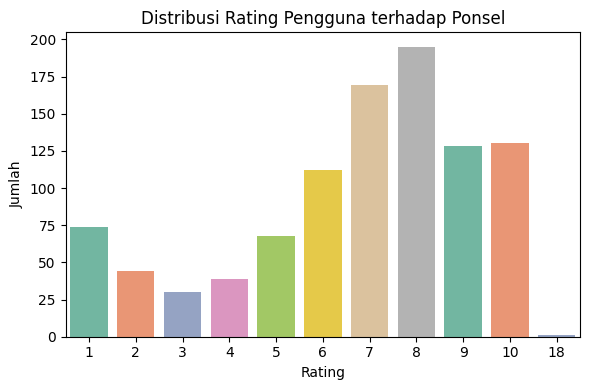

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(x="rating", data=rating, palette="Set2")
plt.title("Distribusi Rating Pengguna terhadap Ponsel")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()


Grafik di atas menunjukkan distribusi frekuensi nilai rating yang diberikan oleh pengguna terhadap berbagai ponsel.

- Skala rating berkisar dari **1 hingga 10**, dengan satu outlier di **18** yang kemungkinan merupakan data tidak valid.
- Rating paling banyak diberikan pada:
  - **8** (hampir 200 pengguna)
  - **7 dan 10**
- Nilai rating rendah (1–4) lebih jarang diberikan.

> 📌 **Insight**:
> - Pengguna cenderung memberikan **rating tinggi** pada ponsel yang mereka gunakan.
> - Perlu dilakukan **penanganan terhadap nilai anomali**, seperti rating `18`.


Distribusi Usia Pengguna

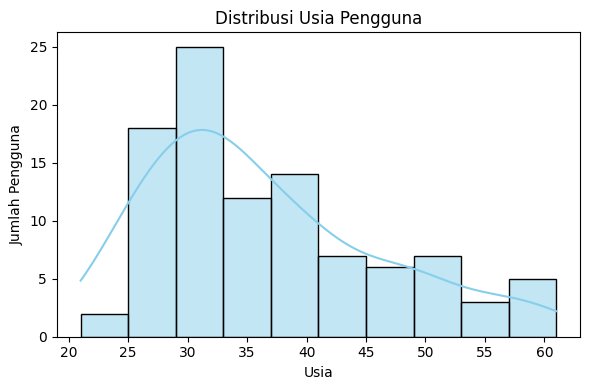

In [12]:
plt.figure(figsize=(6, 4))
sns.histplot(users["age"], bins=10, kde=True, color="skyblue")
plt.title("Distribusi Usia Pengguna")
plt.xlabel("Usia")
plt.ylabel("Jumlah Pengguna")
plt.tight_layout()
plt.show()

Grafik di atas menunjukkan distribusi usia dari pengguna yang memberikan rating terhadap ponsel.

- Mayoritas pengguna berusia **25 hingga 35 tahun**, dengan puncaknya sekitar **30 tahun**.
- Distribusi memiliki **kemiringan ke kanan (right-skewed)** — menandakan lebih sedikit pengguna yang berusia di atas 40 tahun.
- Terdapat pengguna dengan usia hingga **60 tahun**, meskipun dalam jumlah kecil.

Distribusi Harga Ponsel

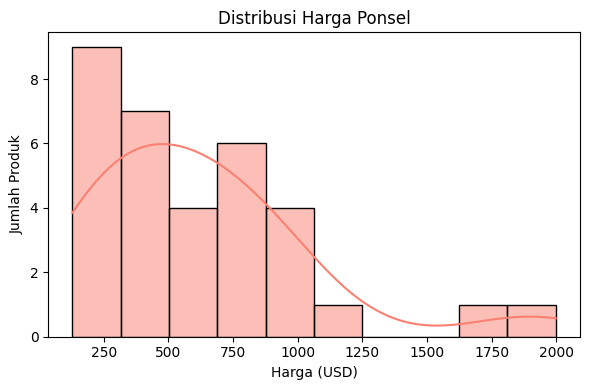

In [13]:
plt.figure(figsize=(6, 4))
sns.histplot(data["price"], bins=10, kde=True, color="salmon")
plt.title("Distribusi Harga Ponsel")
plt.xlabel("Harga (USD)")
plt.ylabel("Jumlah Produk")
plt.tight_layout()
plt.show()

Grafik di atas menunjukkan distribusi harga ponsel dalam dataset, dalam satuan **USD**.

- Sebagian besar ponsel berada dalam rentang harga **$100 hingga $600**.
- Distribusi bersifat **right-skewed (positif)** — menandakan sebagian kecil ponsel berada di kelas **premium** (di atas $1000).

- Terdapat sedikit ponsel dengan harga sangat tinggi, misalnya **$1750 hingga $2000**, yang merupakan flagship atau high-end devices.

Jumlah Produk per Brand

<ipython-input-14-3957074954>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="brand", data=data, order=data["brand"].value_counts().index, palette="viridis")


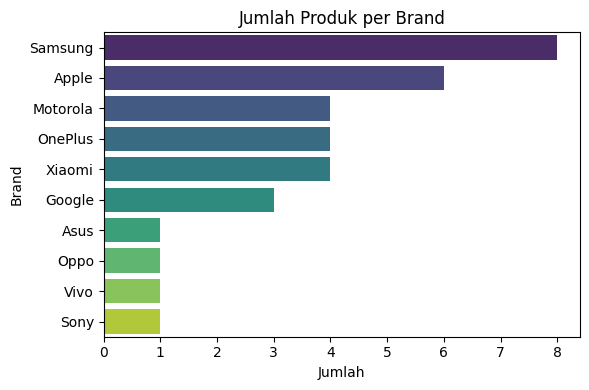

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(y="brand", data=data, order=data["brand"].value_counts().index, palette="viridis")
plt.title("Jumlah Produk per Brand")
plt.xlabel("Jumlah")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()

Grafik di atas menunjukkan jumlah produk (ponsel) yang tersedia pada dataset berdasarkan merek.

- **Samsung** merupakan brand dengan jumlah produk terbanyak (**8 produk**), diikuti oleh:
  - **Apple** (6 produk)
  - **Motorola**, **OnePlus**, dan **Xiaomi** (masing-masing 4 produk)
- Brand seperti **Asus**, **Oppo**, **Vivo**, dan **Sony** hanya memiliki **1 produk** masing-masing.

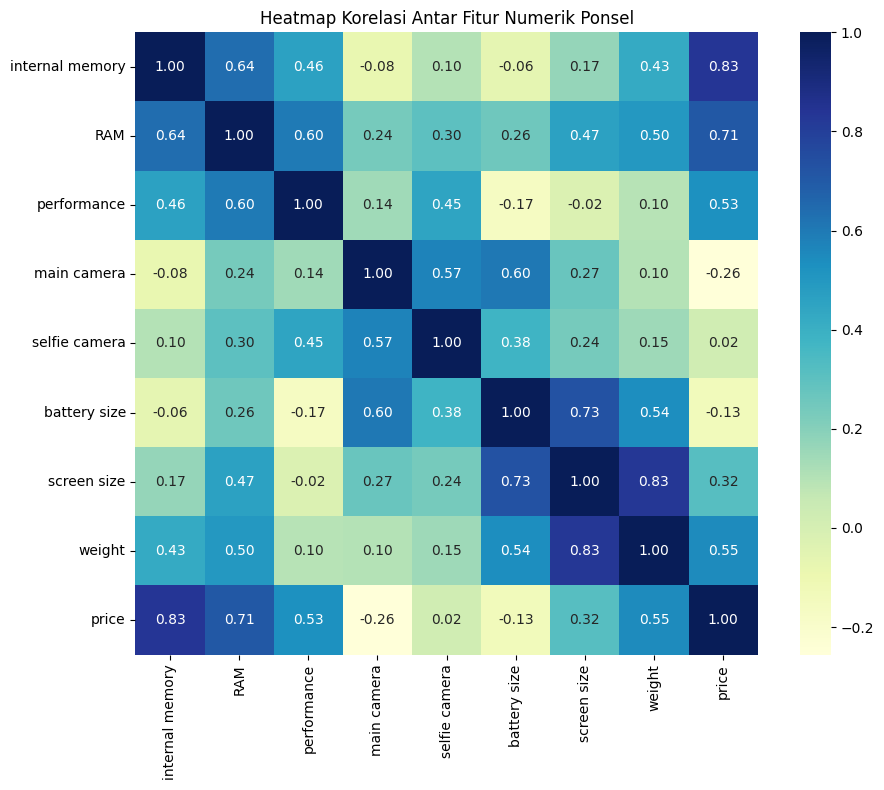

In [15]:
numeric_cols = [
    'internal memory', 'RAM', 'performance', 'main camera',
    'selfie camera', 'battery size', 'screen size', 'weight', 'price'
]

correlation_matrix = data[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True)
plt.title("Heatmap Korelasi Antar Fitur Numerik Ponsel")
plt.tight_layout()
plt.show()

Heatmap di atas menunjukkan tingkat korelasi antar fitur numerik dalam dataset ponsel.

#### 🔍 Highlight Korelasi Tinggi:
- **Internal memory** berkorelasi kuat dengan **price** (`0.83`)
- **RAM** berkorelasi kuat dengan **price** (`0.71`)
- **Screen size** memiliki korelasi tinggi dengan **weight** (`0.83`) dan **battery size** (`0.73`)
- **Performance** memiliki korelasi sedang dengan **RAM** (`0.60`) dan **price** (`0.53`)

#### 📌 Insight:
- Harga ponsel lebih dipengaruhi oleh spesifikasi teknis seperti:
  - **Kapasitas memori**
  - **RAM**
  - **Performa**
- Fitur seperti **main camera** dan **selfie camera** memiliki korelasi rendah terhadap harga.
- Ukuran dan berat ponsel saling berkaitan kuat, logis karena layar besar → berat bertambah.

#Data Preprocessing

Menggabungkan dataset data, rating, dan users menjadi satu.

In [16]:
ratings_data = pd.merge(rating, data, on='cellphone_id')
merged_data = pd.merge(ratings_data, users, on='user_id')
merged_data.head()

,user_id,cellphone_id,rating,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date,age,gender,occupation
0,0,30,1,Motorola,Moto G Play (2021),Android,32,3,1.42,13,5,5000,6.5,204,159,14/01/2021,38,Female,Data analyst
1,0,5,3,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,26/10/2018,38,Female,Data analyst
2,0,10,9,Samsung,Galaxy S22,Android,128,8,8.81,50,10,3700,6.1,167,528,25/02/2022,38,Female,Data analyst
3,0,9,3,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,24/03/2022,38,Female,Data analyst
4,0,23,2,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,29/04/2022,38,Female,Data analyst


Melakukan cek missing value.

In [17]:
#Cek missing value
merged_data.isnull().sum()

,0
user_id,0
cellphone_id,0
rating,0
brand,0
model,0
operating system,0
internal memory,0
RAM,0
performance,0
main camera,0


Output kode di atas memberikan informasi :
- Terdapat 10 missing value pada occupation

Drop missing value.

In [18]:
#Menghapus missing value
merged_data = merged_data.dropna()

Memastikan bahwa tidak terdapat missing value lagi.

In [19]:
#Cek missing value
merged_data.isnull().sum()

,0
user_id,0
cellphone_id,0
rating,0
brand,0
model,0
operating system,0
internal memory,0
RAM,0
performance,0
main camera,0


Output kode di atas memberikan informasi :
- Sudah tidak terdapat missing value.

In [20]:
merged_data = merged_data[merged_data['rating'] != 18]
merged_data['occupation'] = merged_data['occupation'].str.lower()
merged_data['occupation'] = merged_data['occupation'].replace('healthare', 'healthcare')
merged_data['occupation'] = merged_data['occupation'].replace('it', 'information technology')

Menampilkan dataset yang sudah dibersihkan.

In [21]:
#Menampilkan dataset
cleaned_data = merged_data
cleaned_data

,user_id,cellphone_id,rating,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date,age,gender,occupation
0,0,30,1,Motorola,Moto G Play (2021),Android,32,3,1.42,13,5,5000,6.5,204,159,14/01/2021,38,Female,data analyst
1,0,5,3,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,26/10/2018,38,Female,data analyst
2,0,10,9,Samsung,Galaxy S22,Android,128,8,8.81,50,10,3700,6.1,167,528,25/02/2022,38,Female,data analyst
3,0,9,3,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,24/03/2022,38,Female,data analyst
4,0,23,2,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,29/04/2022,38,Female,data analyst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,258,31,5,Motorola,Moto G Pure,Android,32,3,1.02,13,5,4000,6.5,188,129,14/10/2021,25,Male,executive manager
986,258,17,8,Google,Pixel 6 Pro,Android,128,12,7.19,50,11,5003,6.7,210,699,28/10/2021,25,Male,executive manager
987,258,23,9,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,29/04/2022,25,Male,executive manager
988,258,27,8,Xiaomi,Poco F4,Android,128,8,6.98,64,20,4500,6.6,195,428,27/07/2022,25,Male,executive manager


# Data Preparation

In [22]:
#Menghapus data duplikat
cleaned_data = cleaned_data.drop_duplicates('cellphone_id')

Melakukan konversi data series menjadi list.

In [23]:
#Melakukan konversi data series menjadi list
cellphone_id = cleaned_data['cellphone_id'].tolist()
brand = cleaned_data['brand'].tolist()
model = cleaned_data['model'].tolist()
operating_system = cleaned_data['operating system'].tolist()

print(len(cellphone_id))
print(len(brand))
print(len(model))
print(len(operating_system))

33
33
33
33


Membuat dictionary untuk menentukan pasangan key-value

In [24]:
#Membuat dictionary untuk menentukan pasangan key-value
phone_new = pd.DataFrame({
    'cellphone_id': cellphone_id,
    'brand': brand,
    'model': model,
    'operating_system': operating_system,
})

phone_new

,cellphone_id,brand,model,operating_system
0,30,Motorola,Moto G Play (2021),Android
1,5,Apple,iPhone XR,iOS
2,10,Samsung,Galaxy S22,Android
3,9,Samsung,Galaxy A53,Android
4,23,Vivo,X80 Pro,Android
5,8,Samsung,Galaxy A32,Android
6,22,Oppo,Find X5 Pro,Android
7,16,Google,Pixel 6a,Android
8,19,OnePlus,Nord 2T,Android
9,3,Apple,iPhone 13 Pro,iOS


Menggabungkan Data

In [25]:
# Menggabungkan data rating dan data ponsel untuk mendapatkan informasi lengkap
merged_rating_data = pd.merge(rating, data, on='cellphone_id')

Mengambil Kolom yang Relevan

In [26]:
# Mengambil kolom user_id, cellphone_id, dan rating
df = merged_rating_data[['user_id', 'cellphone_id', 'rating']]

Encoding ID ke Format Numerik

In [27]:
# Mengubah tipe data user_id dan cellphone_id menjadi category
user_ids = df['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
df['user'] = df['user_id'].map(user_to_user_encoded)

cellphone_ids = df['cellphone_id'].unique().tolist()
cellphone_to_cellphone_encoded = {x: i for i, x in enumerate(cellphone_ids)}
cellphone_encoded_to_cellphone = {i: x for i, x in enumerate(cellphone_ids)}
df['cellphone'] = df['cellphone_id'].map(cellphone_to_cellphone_encoded)

<ipython-input-27-3042966504>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user'] = df['user_id'].map(user_to_user_encoded)
<ipython-input-27-3042966504>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cellphone'] = df['cellphone_id'].map(cellphone_to_cellphone_encoded)


In [28]:
# Mendapatkan jumlah user dan cellphone
num_users = len(user_to_user_encoded)
num_cellphones = len(cellphone_encoded_to_cellphone)

In [29]:
# Mengubah rating menjadi float
df['rating'] = df['rating'].values.astype(np.float32)

<ipython-input-29-9352933>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = df['rating'].values.astype(np.float32)


In [30]:
# Nilai minimum dan maksimum rating
min_rating = min(df['rating'])
max_rating = max(df['rating'])

print('Number of Users: {}'.format(num_users))
print('Number of Cellphones: {}'.format(num_cellphones))
print('Min Rating: {}'.format(min_rating))
print('Max Rating: {}'.format(max_rating))

Number of Users: 99
Number of Cellphones: 33
Min Rating: 1.0
Max Rating: 18.0


In [31]:
# Mengacak dataset untuk split data training dan validasi
df = df.sample(frac=1, random_state=42)
x = df[['user', 'cellphone']].values
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [32]:
# Membagi dataset menjadi data training dan validasi (80:20)
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(792, 2) (198, 2) (792,) (198,)


In [33]:
vectorizer = TfidfVectorizer(stop_words='english')

In [34]:
# Menggabungkan teks dari kolom-kolom yang relevan
phone_new['combined_features'] = phone_new['brand'] + ' ' + phone_new['model'] + ' ' + phone_new['operating_system']

# Menerapkan TfidfVectorizer pada kolom gabungan
tfidf_matrix = vectorizer.fit_transform(phone_new['combined_features'])

# Menghitung cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

#Model Development Dengan Content Based Filtering

In [35]:
# Membuat fungsi untuk mendapatkan rekomendasi
def get_recommendations(model_name, cosine_sim=cosine_sim):
    # Mendapatkan indeks model
    try:
        idx = phone_new[phone_new['model'] == model_name].index[0]
    except IndexError:
        return "Model not found in the dataset."

    # Mendapatkan skor similarity dengan model lain
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Mengurutkan ponsel berdasarkan skor similarity
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mendapatkan skor dari 10 ponsel teratas (tidak termasuk ponsel itu sendiri)
    sim_scores = sim_scores[1:11]

    # Mendapatkan indeks ponsel
    phone_indices = [i[0] for i in sim_scores]

    # Mengembalikan 10 ponsel teratas
    return phone_new.iloc[phone_indices]


In [36]:
# Mendapatkan rekomendasi untuk "iPhone 13"
recommendations = get_recommendations('iPhone 13')
print("Rekomendasi ponsel mirip dengan 'iPhone 13':")
print(recommendations)

# Mendapatkan rekomendasi untuk "Samsung Galaxy S21 Ultra"
recommendations = get_recommendations('Galaxy S21 Ultra')
print("\nRekomendasi ponsel mirip dengan 'Galaxy S21 Ultra':")
print(recommendations)

# Mendapatkan rekomendasi untuk model yang tidak ada di dataset
recommendations = get_recommendations('Smartphone XYZ')
print("\nRekomendasi ponsel mirip dengan 'Smartphone XYZ':")
recommendations


Rekomendasi ponsel mirip dengan 'iPhone 13':
    cellphone_id     brand               model operating_system  \
9              3     Apple       iPhone 13 Pro              iOS   
18             1     Apple      iPhone 13 Mini              iOS   
16             4     Apple   iPhone 13 Pro Max              iOS   
1              5     Apple           iPhone XR              iOS   
23             0     Apple    iPhone SE (2022)              iOS   
0             30  Motorola  Moto G Play (2021)          Android   
2             10   Samsung          Galaxy S22          Android   
3              9   Samsung          Galaxy A53          Android   
4             23      Vivo             X80 Pro          Android   
5              8   Samsung          Galaxy A32          Android   

                      combined_features  
9               Apple iPhone 13 Pro iOS  
18             Apple iPhone 13 Mini iOS  
16          Apple iPhone 13 Pro Max iOS  
1                   Apple iPhone XR iOS  
23     

'Model not found in the dataset.'

Sistem memberikan daftar 10 ponsel yang paling mirip dengan model iPhone 13 berdasarkan kemiripan fitur teks (brand, model, operating_system) yang telah diproses menggunakan TF-IDF Vectorizer dan cosine similarity.

#Model Development dengan Collaborative Filtering

In [37]:
# Membuat arsitektur model Neural Network untuk Collaborative Filtering
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_cellphones, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_cellphones = num_cellphones
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name="user_embedding",
        )
        self.user_bias = layers.Embedding(
            input_dim=num_users, output_dim=1, name="user_bias"
        )
        self.cellphone_embedding = layers.Embedding(
            input_dim=num_cellphones,
            output_dim=embedding_size,
            name="cellphone_embedding",
        )
        self.cellphone_bias = layers.Embedding(
            input_dim=num_cellphones, output_dim=1, name="cellphone_bias"
        )

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        cellphone_vector = self.cellphone_embedding(inputs[:, 1])
        cellphone_bias = self.cellphone_bias(inputs[:, 1])

        dot_product = tf.tensordot(user_vector, cellphone_vector, 2)

        x = dot_product + user_bias + cellphone_bias

        return tf.nn.sigmoid(x)

# Inisialisasi model
embedding_size = 50
model = RecommenderNet(num_users, num_cellphones, embedding_size)

# Mengompilasi model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

# Melatih model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_val, y_val),
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.6950 - root_mean_squared_error: 0.2330 - val_loss: 0.6901 - val_root_mean_squared_error: 0.2167
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6608 - root_mean_squared_error: 0.1943 - val_loss: 0.6861 - val_root_mean_squared_error: 0.2121
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6435 - root_mean_squared_error: 0.1669 - val_loss: 0.6812 - val_root_mean_squared_error: 0.2062
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6331 - root_mean_squared_error: 0.1605 - val_loss: 0.6771 - val_root_mean_squared_error: 0.2011
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6421 - root_mean_squared_error: 0.1506 - val_loss: 0.6762 - val_root_mean_squared_error: 0.2001
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6375 - root_mean_squared_error: 0.1500 - val_loss: 0.6765 - val_root_mean_squared_error: 0.2004
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6

- **Fitur**: Data interaksi berupa `user_id`, `cellphone_id`, dan `rating`.
- **Langkah-langkah:**
  1. Menggabungkan data rating dengan metadata ponsel.
  2. Encoding `user_id` dan `cellphone_id` ke bentuk numerik.
  3. Membuat **model neural network**:
     - Menggunakan **Embedding Layer** untuk user dan ponsel.
     - Melakukan dot product + bias dan aktivasi sigmoid.
  4. Model dilatih dengan **loss: Binary Crossentropy** dan metrik **RMSE**.
  5. Setelah pelatihan, model dapat:
     - Memprediksi rating untuk ponsel yang belum dirating user.
     - Memberikan rekomendasi top-N berdasarkan skor prediksi tertinggi.

In [38]:
# Mendapatkan data pengguna acak untuk percobaan rekomendasi
user_id = df['user_id'].sample(1).iloc[0]
cellphones_rated_by_user = df[df['user_id'] == user_id]

# Mendapatkan data ponsel yang belum dirating oleh pengguna
cellphone_not_rated = data[
    ~data['cellphone_id'].isin(cellphones_rated_by_user['cellphone_id'].values)
]['cellphone_id']
cellphone_not_rated = list(
    set(cellphone_not_rated).intersection(set(cellphone_to_cellphone_encoded.keys()))
)

cellphone_not_rated = [[cellphone_to_cellphone_encoded.get(x)] for x in cellphone_not_rated]
user_encoder = user_to_user_encoded.get(user_id)
user_cellphone_array = np.hstack(
    (np.full((len(cellphone_not_rated), 1), user_encoder), cellphone_not_rated)
)

# Mendapatkan prediksi rating dari model
ratings = model.predict(user_cellphone_array).flatten()

# Mengurutkan ponsel berdasarkan prediksi rating tertinggi
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_cellphone_ids = [
    cellphone_encoded_to_cellphone.get(cellphone_not_rated[x][0]) for x in top_ratings_indices
]

# Menampilkan rekomendasi ponsel
print('Showing recommendations for user: {}'.format(user_id))
print('===' * 9)
print('Cellphones with high ratings from user')
print('----' * 8)

top_cellphones_user = (
    cellphones_rated_by_user.sort_values(by='rating', ascending=False)
    .head(5)
    .cellphone_id.values
)

data_cellphone_df = data.set_index('cellphone_id')
for cellphone_id in top_cellphones_user:
    print(data_cellphone_df.loc[cellphone_id]['model'])

print('----' * 8)
print('Top 10 recommended cellphones')
print('----' * 8)

for cellphone_id in recommended_cellphone_ids:
    print(data_cellphone_df.loc[cellphone_id]['model'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Showing recommendations for user: 60
Cellphones with high ratings from user
--------------------------------
Moto G Pure
12 Pro
Moto G Power (2022)
Moto G Stylus (2022)
Pixel 6a
--------------------------------
Top 10 recommended cellphones
--------------------------------
iPhone SE (2022)
iPhone 13 Pro Max
iPhone 13 Pro
Find X5 Pro
11T Pro
iPhone 13
10 Pro
Pixel 6 Pro 
Galaxy S22
Galaxy S22 Ultra


kode diatas adalah rekomendasi menggunakan  Collaborative Filtering

#Evaluasi

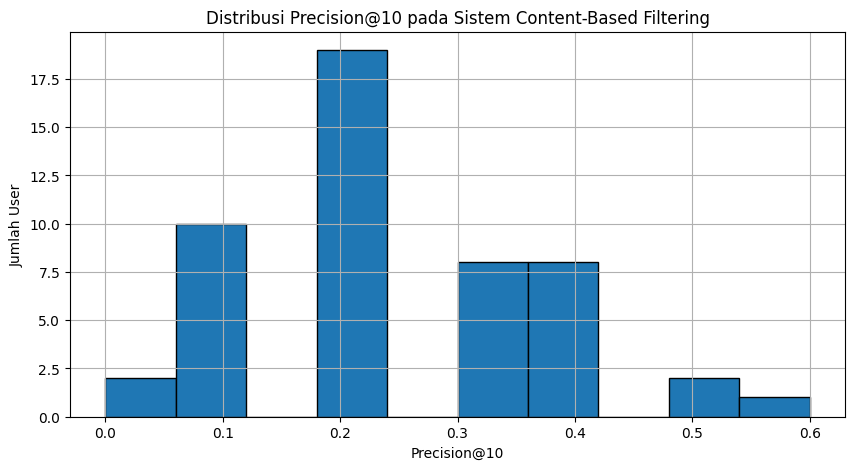

In [39]:
import matplotlib.pyplot as plt

# Buat list untuk menyimpan hasil evaluasi
precision_scores = []

# Pilih subset user agar evaluasi tidak terlalu berat
sample_users = rating['user_id'].unique()[:50]  # misalnya 50 user pertama

for user in sample_users:
    # Ponsel yang disukai user ini
    liked_phones = rating[(rating['user_id'] == user) & (rating['rating'] >= 4)]['cellphone_id']

    if liked_phones.empty:
        continue

    # Ambil salah satu ponsel yang disukai sebagai acuan
    sample_phone_id = liked_phones.values[0]
    try:
        model_name = phone_new[phone_new['cellphone_id'] == sample_phone_id]['model'].values[0]
    except IndexError:
        continue

    # Dapatkan rekomendasi
    recommendations = get_recommendations(model_name)
    if isinstance(recommendations, str):
        continue

    recommended_ids = recommendations['cellphone_id'].tolist()

    # Bandingkan apakah ponsel yang disukai user ada di antara rekomendasi
    true_positives = len(set(recommended_ids) & set(liked_phones))

    precision_at_10 = true_positives / 10
    precision_scores.append(precision_at_10)

# Plot distribusi Precision@10
plt.figure(figsize=(10, 5))
plt.hist(precision_scores, bins=10, edgecolor='black')
plt.title('Distribusi Precision@10 pada Sistem Content-Based Filtering')
plt.xlabel('Precision@10')
plt.ylabel('Jumlah User')
plt.grid(True)
plt.show()


Grafik di atas menunjukkan distribusi Precision@10 pada sistem Content-Based Filtering. Grafik ini menggambarkan jumlah pengguna pada berbagai nilai Precision@10, dengan sebagian besar pengguna memiliki Precision@10 rendah, dan sejumlah kecil pengguna menunjukkan nilai Precision@10 yang lebih tinggi.

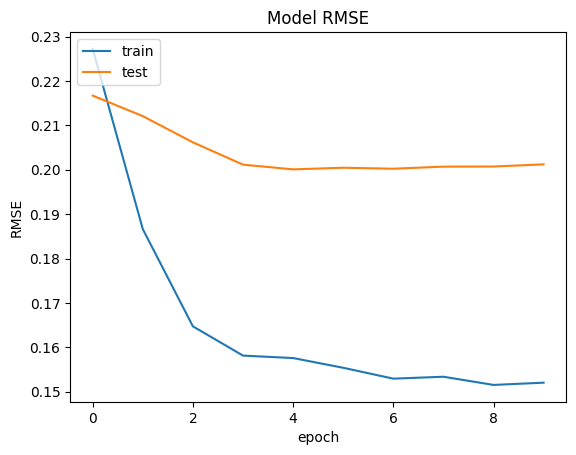

In [40]:
# Plot hasil pelatihan model
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Grafik ini menunjukkan perkembangan **Root Mean Squared Error (RMSE)** selama proses pelatihan model rekomendasi berbasis Neural Network.

#### 🧾 Keterangan:
- **Garis biru**: RMSE pada data pelatihan (*train*).
- **Garis oranye**: RMSE pada data validasi (*test*).

#### 🔍 Insight:
- RMSE pada data pelatihan terus menurun dari awal hingga akhir, menandakan model belajar dengan baik terhadap data historis.
- RMSE pada data validasi juga menurun secara signifikan pada awal epoch, kemudian stabil di sekitar nilai **0.2012**.
- Tidak terjadi peningkatan drastis (*spike*) pada RMSE validasi, sehingga **overfitting tidak terdeteksi secara signifikan**.

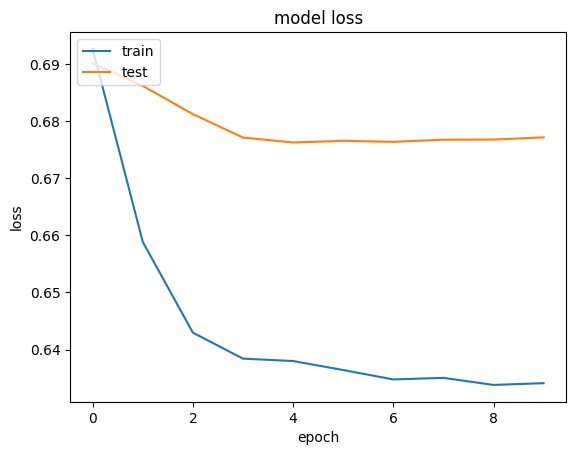

In [41]:
# Plot loss model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Grafik di atas menunjukkan perkembangan nilai loss selama proses pelatihan model rekomendasi berbasis Neural Network menggunakan Collaborative Filtering.

#### 📊 Penjelasan:
- **Garis biru** menunjukkan *training loss*.
- **Garis oranye** menunjukkan *validation loss* (test).

#### 🔍 Insight:
- Terlihat bahwa nilai training loss **terus menurun stabil**, menandakan model mampu mempelajari pola data dengan baik.
- Validation loss juga ikut menurun di awal, lalu mulai stagnan setelah epoch ke-4 hingga ke-10.
- Tidak ada overfitting yang signifikan hingga epoch ke-10, namun **gap antara training dan validation loss** menunjukkan bahwa model masih dapat ditingkatkan melalui:
  - **Regularisasi** (dropout atau weight decay)
  - **Penyesuaian arsitektur embedding**
  - **Peningkatan jumlah data rating**